In [10]:
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from typing import TypedDict,List
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import BaseMessage,AIMessage,HumanMessage
from dotenv import load_dotenv

In [11]:
load_dotenv()
model=ChatOpenAI()

In [ ]:
class AgentState(TypedDict):
    current_post: str
    feedback: str
    count: int =0

In [13]:
GENERATE = "generate"
SHOULD_CONTINUE = "should_continue"
REFLECT = "reflect"

In [14]:
def generate_node(state: AgentState) -> AgentState:
    """Generate or improve the post"""
    
    
    if state['count'] == 0:
        # Initial generation
        template = PromptTemplate(
            template=(
            "You are a Twitter, LinkedIn, and Instagram post generator. "
            "Evaluate the user's goal and generate the best possible viral, classy, or Gen-Z style post for {app}, "
            "based on the topic: {topic}."
            ),
            input_variables=["app", "topic"]
        )

        # print("📝 Creating initial post...")
    else:
        # Improve based on feedback
        template = PromptTemplate(
            template=f"""Improve this  post based on feedback:
            
            Current post: {state['current_post']}
            Feedback: {state['feedback']}
            
            Make it more viral and engaging.""",
            input_variables=[]
        )
        # print("🔧 Improving post based on feedback...")
    
    chain = template | model | StrOutputParser()
    result = chain.invoke({'app':'LinkedIn','topic':'Why extra languages of Foreign countries must be taught in Indian schools'})
    
    state['current_post'] = result
    # print(f"✅ Generated: {result[:50]}...")
    return state


def reflect_node(state: AgentState) -> AgentState:
    """Analyze the post and provide feedback"""
    # print("🔍 REFLECT NODE - Analyzing post...")
    
    template = PromptTemplate(
        template=f"""Analyze this  post and provide specific feedback:
        
        Post: {state['current_post']}
        
        Give brief, actionable feedback for improvement focusing on engagement and viral potential.""",
        input_variables=[]
    )
    
    chain = template | model | StrOutputParser()
    feedback = chain.invoke({})
    
    state['feedback'] = feedback
    print(f"💡 Feedback: {feedback[:100]}...")
    return state


def should_continue_node(state: AgentState) -> AgentState:
    """Decision node - increment counter and prepare for routing"""
    #print(f"🤔 SHOULD_CONTINUE NODE - Current count: {state['count']}")
    state['count'] += 1
    #print(f"📊 Updated count to: {state['count']}")
    return state


def routing_function(state: AgentState) -> str:
    """Route to either 'reflect' or 'end' based on count"""
    if state['count'] >= 6:
        # print("🏁 ROUTING: Going to END (max iterations reached)")
        return "end"
    else:
        # print("➡️ ROUTING: Going to REFLECT")
        return "reflect"




In [15]:
# Build the graph exactly like your diagram
graph = StateGraph(AgentState)

# Add nodes
graph.add_node(GENERATE, generate_node)
graph.add_node(SHOULD_CONTINUE, should_continue_node)
graph.add_node(REFLECT, reflect_node)

# Add edges exactly matching your diagram
graph.add_edge(START, GENERATE)                    # start -> generate
graph.add_edge(GENERATE, SHOULD_CONTINUE)          # generate -> should_continue
graph.add_conditional_edges(                       # should_continue -> reflect/end
    SHOULD_CONTINUE,
    routing_function,
    {
        "reflect": REFLECT,
        "end": END
    }
)
graph.add_edge(REFLECT, GENERATE)                  # reflect -> generate (loop back)

# Compile the graph
app = graph.compile()

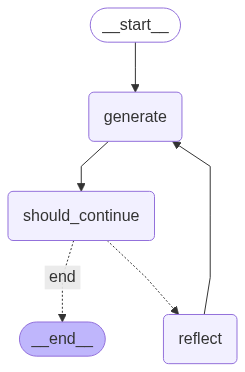

In [16]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
result = app.invoke({
    'current_post': '',
    'feedback': '',
    'count': 0
})

print("\n" + "=" * 50)
print("🎯 FINAL RESULT")
print("=" * 50)
print(result['current_post'])




💡 Feedback: This post could benefit from more specific examples or statistics to make the importance of teaching...
💡 Feedback: To improve engagement and viral potential, consider adding more specific examples of how learning fo...
💡 Feedback: This post is engaging and informative, but to increase its viral potential, consider adding personal...
💡 Feedback: This post does a great job of highlighting the benefits of learning a foreign language and encouragi...
💡 Feedback: This post does a great job of highlighting the benefits of learning a foreign language and encouragi...

🎯 FINAL RESULT
Title: Embrace the Power of Language Learning: Share Your Story 🌍

In a country as diverse as India, the impact of learning foreign languages goes beyond just communication - it can actually reshape our brains and enhance cognitive abilities. Our youth are exploring the beauty of global languages, opening up a world of possibilities.

When we integrate foreign language education into our schools, we a